# Libraries 

In [630]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2 as cv 
import os
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Phase 1 - Data Preparation and Feature Extraction 

# Load MoveNet Model 

In [309]:
# Corrected file path with double backslashes
model = hub.load("C:\\Users\\Admin\\PycharmProjects\\Fall Detection - Jupyter\\movenet-tensorflow2-multipose-lightning-v1")
movenet = model.signatures['serving_default']

# MoveNet Model Build 

In [311]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))

    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0, 255, 0), -1)

EDGES = {
    (0, 1): 'm', (0, 2): 'c', (1, 3): 'm', (2, 4): 'c', (0, 5): 'm',
    (0, 6): 'c', (5, 7): 'm', (7, 9): 'm', (6, 8): 'c', (8, 10): 'c',
    (5, 6): 'y', (5, 11): 'm', (6, 12): 'c', (11, 12): 'y', (11, 13): 'm',
    (13, 15): 'm', (12, 14): 'c', (14, 16): 'c'
}

def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))

    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]

        if (c1 > confidence_threshold) & (c2 > confidence_threshold):
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)

def loop_through_persons(frame, keypoints_scores, edges, confidence_threshold):
    for person in keypoints_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)


def process_images_for_keypoints(input_folder, base_keypoint_image_folder, base_keypoint_numpy_folder, activity_name):
    if not os.path.exists(base_keypoint_image_folder):
        os.makedirs(base_keypoint_image_folder)
    if not os.path.exists(base_keypoint_numpy_folder):
        os.makedirs(base_keypoint_numpy_folder)

    # Create directories based on activity name
    keypoint_image_folder = os.path.join(base_keypoint_image_folder, f'{activity_name}')
    keypoint_numpy_folder = os.path.join(base_keypoint_numpy_folder, f'{activity_name}')

    if not os.path.exists(keypoint_image_folder):
        os.makedirs(keypoint_image_folder)
    if not os.path.exists(keypoint_numpy_folder):
        os.makedirs(keypoint_numpy_folder)

    images = sorted(
        [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.jpg') or f.endswith('.png')])

    for i, img_path in enumerate(tqdm(images, desc=f"Processing frames for '{activity_name}'")):
        frame = cv2.imread(img_path)
        if frame is None:
            continue

        # Preprocess image for MoveNet
        img = tf.image.resize_with_pad(tf.expand_dims(frame, axis=0), 192, 192)
        input_img = tf.cast(img, dtype=tf.int32)

        results = movenet(input_img)
        keypoints_scores = results['output_0'].numpy()[:, :, :51].reshape((6, 17, 3))

        loop_through_persons(frame, keypoints_scores, EDGES, 0.2)

        # Save keypoints visualization image
        output_img_path = os.path.join(keypoint_image_folder, f'keypoints_{i:04d}.png')
        cv2.imwrite(output_img_path, frame)

        # Preprocess image and save
        preprocessed_img = preprocess_image(img_path)
        preprocessed_img_path = os.path.join(keypoint_image_folder, f'preprocessed_{i:04d}.png')
        cv2.imwrite(preprocessed_img_path, preprocessed_img)

        # Save keypoints numpy file
        output_numpy_path = os.path.join(keypoint_numpy_folder, f'keypoints_{i:04d}.npy')
        np.save(output_numpy_path, keypoints_scores)


## Load Dataset, Directories and Execute Loop 

In [313]:
dataset_dir = "C:/Users/Admin/PycharmProjects/Fall Detection - Jupyter/UP Fall Dataset"

In [314]:
base_keypoint_image_folder = 'Keypoints Image Results'
base_keypoint_numpy_folder = 'Keypoints Numpy Results'

In [315]:
for activity_folder in os.listdir(dataset_dir):
    input_folder = os.path.join(dataset_dir, activity_folder)

    if os.path.isdir(input_folder):  # Ensure it's a folder
        print(f"Processing activity: {activity_folder}")

        # Process images for keypoints with a progress bar for each class
        process_images_for_keypoints(input_folder, base_keypoint_image_folder, base_keypoint_numpy_folder, activity_folder)


Processing activity: Falling backwards - Activity 1


Processing frames for 'Falling backwards - Activity 1': 100%|██████████████████████████| 11/11 [00:04<00:00,  2.44it/s]


Processing activity: Falling forward using hands - Activity 2


Processing frames for 'Falling forward using hands - Activity 2': 100%|████████████████| 12/12 [00:04<00:00,  2.52it/s]


Processing activity: Falling forward using knees - Activity 3


Processing frames for 'Falling forward using knees - Activity 3': 100%|██████████████████| 8/8 [00:03<00:00,  2.50it/s]


Processing activity: Falling from seated position - Activity 5


Processing frames for 'Falling from seated position - Activity 5': 100%|███████████████| 19/19 [00:07<00:00,  2.67it/s]


Processing activity: Falling sideways - Activity 4


Processing frames for 'Falling sideways - Activity 4': 100%|█████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Processing activity: Jumping - Activity 10


Processing frames for 'Jumping - Activity 10': 100%|█████████████████████████████████████| 6/6 [00:02<00:00,  2.91it/s]


Processing activity: Laying Down - Activity 11


Processing frames for 'Laying Down - Activity 11': 100%|█████████████████████████████████| 6/6 [00:02<00:00,  2.66it/s]


Processing activity: Picking an object - Activity 9


Processing frames for 'Picking an object - Activity 9': 100%|████████████████████████████| 6/6 [00:02<00:00,  2.89it/s]


Processing activity: Sitting - Activity 8


Processing frames for 'Sitting - Activity 8': 100%|██████████████████████████████████████| 6/6 [00:02<00:00,  2.62it/s]


Processing activity: Standing - Activity 7


Processing frames for 'Standing - Activity 7': 100%|███████████████████████████████████| 10/10 [00:04<00:00,  2.44it/s]


Processing activity: Walking - Activity 6


Processing frames for 'Walking - Activity 6': 100%|████████████████████████████████████| 12/12 [00:05<00:00,  2.27it/s]


## Vizualise the first frame of each class

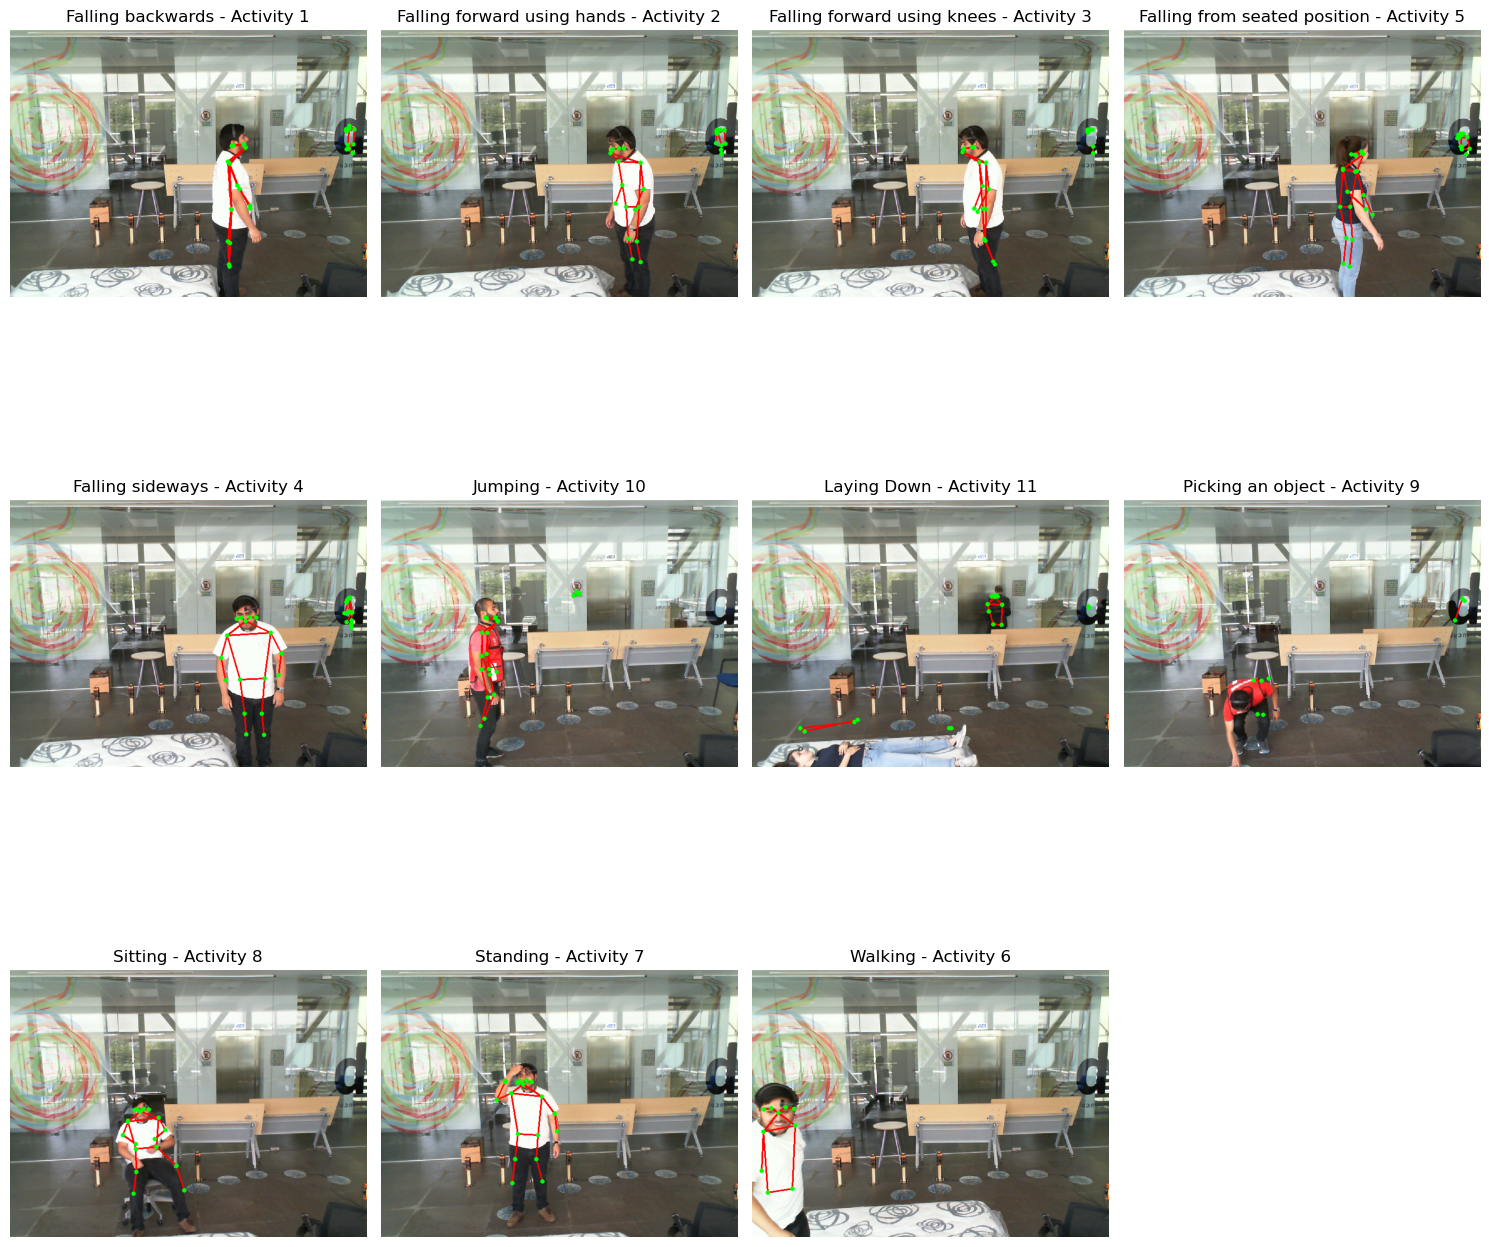

In [317]:
# Path to the directory containing class folders with images
keypoints_image_results_dir = r"C:\Users\Admin\PycharmProjects\Fall Detection - Jupyter\Keypoints Image Results"

output_image_path = r"C:\Users\Admin\PycharmProjects\Fall Detection - Jupyter\Keypoints Image Results\keypoints_image_grid.png"

# Get list of class directories
class_dirs = [d for d in os.listdir(keypoints_image_results_dir) if os.path.isdir(os.path.join(keypoints_image_results_dir, d))]

# Number of classes (folders)
num_classes = len(class_dirs)

# Set up the number of rows and columns for the grid
num_cols = 4 
num_rows = (num_classes // num_cols) + (1 if num_classes % num_cols != 0 else 0)

# Set up the figure size
plt.figure(figsize=(15, 5 * num_rows))

# Loop through each class directory and load the first image
for i, class_dir in enumerate(class_dirs):
    class_path = os.path.join(keypoints_image_results_dir, class_dir)
    
    # Get the list of images in the class folder
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    if image_files:
        # Sort and select the first image 
        first_image_path = os.path.join(class_path, sorted(image_files)[0])
        
        # Read the image using OpenCV
        img = cv2.imread(first_image_path)
        
        # Convert the image from BGR (OpenCV format) to RGB for displaying with matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Plot the image in the grid
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img_rgb)
        plt.title(class_dir)  # Set the title as the class name
        plt.axis('off')  # Hide the axes for better visualization

# Adjust layout
plt.tight_layout()
plt.savefig(output_image_path, dpi=300, bbox_inches='tight') 
plt.show()

# Motion Analysis - Optical Flow Algorithm 

In [601]:
def calculate_key_motion_features(frames):
    """Calculate key motion features like average magnitude, variance of magnitude, and dominant direction from the optical flow."""
    flow_features = []

    for i in range(len(frames) - 1):
        prvs = cv.cvtColor(frames[i], cv.COLOR_BGR2GRAY)  # Convert the first image to grayscale
        next = cv.cvtColor(frames[i + 1], cv.COLOR_BGR2GRAY)  # Convert the second image to grayscale

        # Calculate dense optical flow using Farneback method
        flow = cv.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # Calculate magnitude and angle of flow vectors
        mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])

        # Calculate key motion features: average magnitude, variance of magnitude, and dominant direction
        avg_magnitude = np.mean(mag)
        variance_magnitude = np.var(mag)
        dominant_direction = np.mean(ang)

        # Append the features to the flow_features list
        features = [avg_magnitude, variance_magnitude, dominant_direction]
        flow_features.append(features)

    return np.array(flow_features)

def process_image_frames_key_features(frame_folder, base_output_numpy_folder, activity_name):
    """Process frames to calculate and save key motion features."""
    frames = sorted(
        [os.path.join(frame_folder, f) for f in os.listdir(frame_folder) if f.endswith('.jpg') or f.endswith('.png')]
    )

    if len(frames) < 6:
        print(f"Not enough frames to process in {activity_name}.")
        return

    # Create directories based on activity name
    output_numpy_folder = os.path.join(base_output_numpy_folder, f'{activity_name}')

    if not os.path.exists(output_numpy_folder):
        os.makedirs(output_numpy_folder)

    for i in tqdm(range(len(frames) - 1), desc=f"Processing key motion features for '{activity_name}'"):
        frame_sequence = []

        for j in range(2):  # Taking a sequence of two frames at a time
            frame_path = frames[i + j]
            frame = cv.imread(frame_path)  # Load the image at its original resolution
            if frame is None:
                continue
            frame_sequence.append(frame)

        if len(frame_sequence) < 2:
            continue

        # Calculate key motion features for the frame sequence
        flow_features = calculate_key_motion_features(frame_sequence)

        # Save the key motion features to a numpy file (for each frame)
        output_numpy_path = os.path.join(output_numpy_folder, f'key_features_{i:04d}.npy')
        np.save(output_numpy_path, flow_features)  # Only summary statistics are saved (no image data)

# Main directory where the images are stored
image_base_folder = r"C:\Users\Admin\PycharmProjects\Fall Detection - Jupyter\UP Fall Dataset"

# Define base output folders
base_output_numpy_folder = 'Key Motion Features Results'

# Loop through each class/activity folder in the dataset directory
for activity_folder in os.listdir(image_base_folder):
    image_folder = os.path.join(image_base_folder, activity_folder)

    if os.path.isdir(image_folder):
        activity_name = activity_folder

        print(f"Processing key motion features for activity: {activity_name}")

        # Process images to calculate key motion features and store first frame data
        process_image_frames_key_features(image_folder, base_output_numpy_folder, activity_name)

print("Processing complete. Key motion features saved as numpy files.")


Processing key motion features for activity: Falling backwards - Activity 1


Processing key motion features for 'Falling backwards - Activity 1': 100%|█████████████| 10/10 [00:00<00:00, 12.10it/s]


Processing key motion features for activity: Falling forward using hands - Activity 2


Processing key motion features for 'Falling forward using hands - Activity 2': 100%|███| 11/11 [00:00<00:00, 11.62it/s]


Processing key motion features for activity: Falling forward using knees - Activity 3


Processing key motion features for 'Falling forward using knees - Activity 3': 100%|█████| 7/7 [00:00<00:00, 12.09it/s]


Processing key motion features for activity: Falling from seated position - Activity 5


Processing key motion features for 'Falling from seated position - Activity 5': 100%|██| 18/18 [00:01<00:00, 12.20it/s]


Processing key motion features for activity: Falling sideways - Activity 4
Not enough frames to process in Falling sideways - Activity 4.
Processing key motion features for activity: Jumping - Activity 10


Processing key motion features for 'Jumping - Activity 10': 100%|████████████████████████| 5/5 [00:00<00:00, 11.63it/s]


Processing key motion features for activity: Laying Down - Activity 11


Processing key motion features for 'Laying Down - Activity 11': 100%|████████████████████| 5/5 [00:00<00:00, 11.96it/s]


Processing key motion features for activity: Picking an object - Activity 9


Processing key motion features for 'Picking an object - Activity 9': 100%|███████████████| 5/5 [00:00<00:00, 11.74it/s]


Processing key motion features for activity: Sitting - Activity 8


Processing key motion features for 'Sitting - Activity 8': 100%|█████████████████████████| 5/5 [00:00<00:00, 12.17it/s]


Processing key motion features for activity: Standing - Activity 7


Processing key motion features for 'Standing - Activity 7': 100%|████████████████████████| 9/9 [00:00<00:00, 11.76it/s]


Processing key motion features for activity: Walking - Activity 6


Processing key motion features for 'Walking - Activity 6': 100%|███████████████████████| 11/11 [00:00<00:00, 12.26it/s]

Processing complete. Key motion features saved as numpy files.


# Vizualisation of Motion Analysis 

In [558]:
def calculate_and_visualize_optical_flow(prvs, next, index, output_folder, numpy_output_folder):
    # Calculate dense optical flow using Farneback method
    flow = cv.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])

    # Vector field visualization
    hsv_mask = np.zeros_like(cv.cvtColor(prvs, cv.COLOR_GRAY2BGR))
    hsv_mask[..., 1] = 255
    hsv_mask[..., 0] = ang * 180 / np.pi / 2
    hsv_mask[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    rgb = cv.cvtColor(hsv_mask, cv.COLOR_HSV2BGR)
    cv.imwrite(os.path.join(output_folder, f'vector_field_{index:04d}.png'), rgb)

    # Heatmap of motion magnitude
    plt.figure(figsize=(10, 5))
    plt.imshow(mag, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.savefig(os.path.join(output_folder, f'magnitude_heatmap_{index:04d}.png'))
    plt.close()

    # Histogram of motion directions
    plt.figure(figsize=(10, 5))
    plt.hist(ang.flatten(), bins=30, color='r', alpha=0.75)
    plt.title('Histogram of Motion Directions')
    plt.xlabel('Angle (radians)')
    plt.ylabel('Frequency')
    plt.savefig(os.path.join(output_folder, f'direction_histogram_{index:04d}.png'))
    plt.close()

    # Save results as numpy arrays
    np.save(os.path.join(numpy_output_folder, f'motion_magnitude_{index:04d}.npy'), mag)
    np.save(os.path.join(numpy_output_folder, f'motion_angle_{index:04d}.npy'), ang)
    np.save(os.path.join(numpy_output_folder, f'optical_flow_{index:04d}.npy'), flow)

    # Return key motion features
    avg_magnitude = np.mean(mag)
    variance_magnitude = np.var(mag)
    dominant_direction = np.mean(ang)
    return [avg_magnitude, variance_magnitude, dominant_direction], rgb, mag, ang


In [559]:
def process_video_frames(folder_path, output_base_path, numpy_output_base_path):
    frame_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])
    if len(frame_files) < 2:
        print("Not enough frames to process.")
        return

    # Create output folders for image and numpy files
    output_folder = os.path.join(output_base_path, os.path.basename(folder_path))
    numpy_output_folder = os.path.join(numpy_output_base_path, os.path.basename(folder_path))
    
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(numpy_output_folder, exist_ok=True)

    # Store the first frame's results for grid visualization
    vector_fields = []
    heatmaps = []
    histograms = []
    class_name = os.path.basename(folder_path)

    # Process frames
    for i in tqdm(range(len(frame_files) - 1), desc=f'Processing frames for {class_name}'):
        frame1 = cv.imread(frame_files[i], cv.IMREAD_GRAYSCALE)
        frame2 = cv.imread(frame_files[i + 1], cv.IMREAD_GRAYSCALE)
        if frame1 is None or frame2 is None:
            continue

        # Generate optical flow results and save numpy files
        features, vector_field, mag, ang = calculate_and_visualize_optical_flow(frame1, frame2, i, output_folder, numpy_output_folder)

        # Store only the first frame's results for grid visualization
        if i == 0:
            vector_fields.append(vector_field)
            heatmaps.append(mag)
            histograms.append(ang)

    return vector_fields, heatmaps, histograms

In [560]:
def visualize_motion_analysis_grid(base_folder, output_base, numpy_output_base, num_cols=3):
    """Visualize the first frame results from each class in a grid for each motion analysis statistic."""
    class_dirs = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]
    num_classes = len(class_dirs)
    num_rows = (num_classes // num_cols) + (1 if num_classes % num_cols != 0 else 0)

    # Prepare grids for vector fields, heatmaps, and histograms
    fig_vector_field, axs_vector_field = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig_heatmap, axs_heatmap = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig_histogram, axs_histogram = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    for i, class_dir in enumerate(class_dirs):
        class_path = os.path.join(base_folder, class_dir)

        # Process frames and collect results for the first frame of each class
        vector_fields, heatmaps, histograms = process_video_frames(class_path, output_base, numpy_output_base)

        # Plot results for the first frame
        if vector_fields and heatmaps and histograms:
            row, col = divmod(i, num_cols)

            # Plot vector field
            axs_vector_field[row, col].imshow(cv.cvtColor(vector_fields[0], cv.COLOR_BGR2RGB))
            axs_vector_field[row, col].set_title(f"Vector Field: {class_dir}")
            axs_vector_field[row, col].axis('off')

            # Plot heatmap
            im = axs_heatmap[row, col].imshow(heatmaps[0], cmap='hot', interpolation='nearest')
            axs_heatmap[row, col].set_title(f"Heatmap: {class_dir}")
            axs_heatmap[row, col].axis('off')
            fig_heatmap.colorbar(im, ax=axs_heatmap[row, col])

            # Plot histogram
            hist_values, hist_bins = np.histogram(histograms[0].flatten(), bins=30)
            axs_histogram[row, col].bar(hist_bins[:-1], hist_values, width=np.diff(hist_bins), color='r', alpha=0.75)
            axs_histogram[row, col].set_title(f"Histogram: {class_dir}")
            axs_histogram[row, col].set_xlabel('Angle (radians)')
            axs_histogram[row, col].set_ylabel('Frequency')

    # Adjust layout and save the grids with titles
    fig_vector_field.tight_layout()
    fig_heatmap.tight_layout()
    fig_histogram.tight_layout()

    # Save each grid with a specific title
    fig_vector_field.suptitle('Vector Field Grid', fontsize=16)
    fig_heatmap.suptitle('Heatmap Grid', fontsize=16)
    fig_histogram.suptitle('Histogram Grid', fontsize=16)

    # Save each grid in the OF Image Results folder
    fig_vector_field.savefig(os.path.join(output_base, 'vector_field_grid.png'), dpi=300)
    fig_heatmap.savefig(os.path.join(output_base, 'heatmap_grid.png'), dpi=300)
    fig_histogram.savefig(os.path.join(output_base, 'histogram_grid.png'), dpi=300)

    plt.show()

Processing frames for Falling backwards - Activity 1: 100%|████████████████████████████| 10/10 [00:03<00:00,  2.87it/s]
Processing frames for Falling forward using hands - Activity 2: 100%|██████████████████| 11/11 [00:03<00:00,  2.78it/s]
Processing frames for Falling forward using knees - Activity 3: 100%|████████████████████| 7/7 [00:02<00:00,  2.75it/s]
Processing frames for Falling from seated position - Activity 5: 100%|█████████████████| 18/18 [00:07<00:00,  2.33it/s]
Processing frames for Falling sideways - Activity 4: 100%|███████████████████████████████| 3/3 [00:01<00:00,  2.86it/s]
Processing frames for Laying Down - Activity 11: 100%|███████████████████████████████████| 5/5 [00:01<00:00,  2.69it/s]
Processing frames for Picking an object - Activity 9: 100%|██████████████████████████████| 5/5 [00:01<00:00,  2.64it/s]
Processing frames for Walking - Activity 6: 100%|██████████████████████████████████████| 11/11 [00:03<00:00,  2.81it/s]


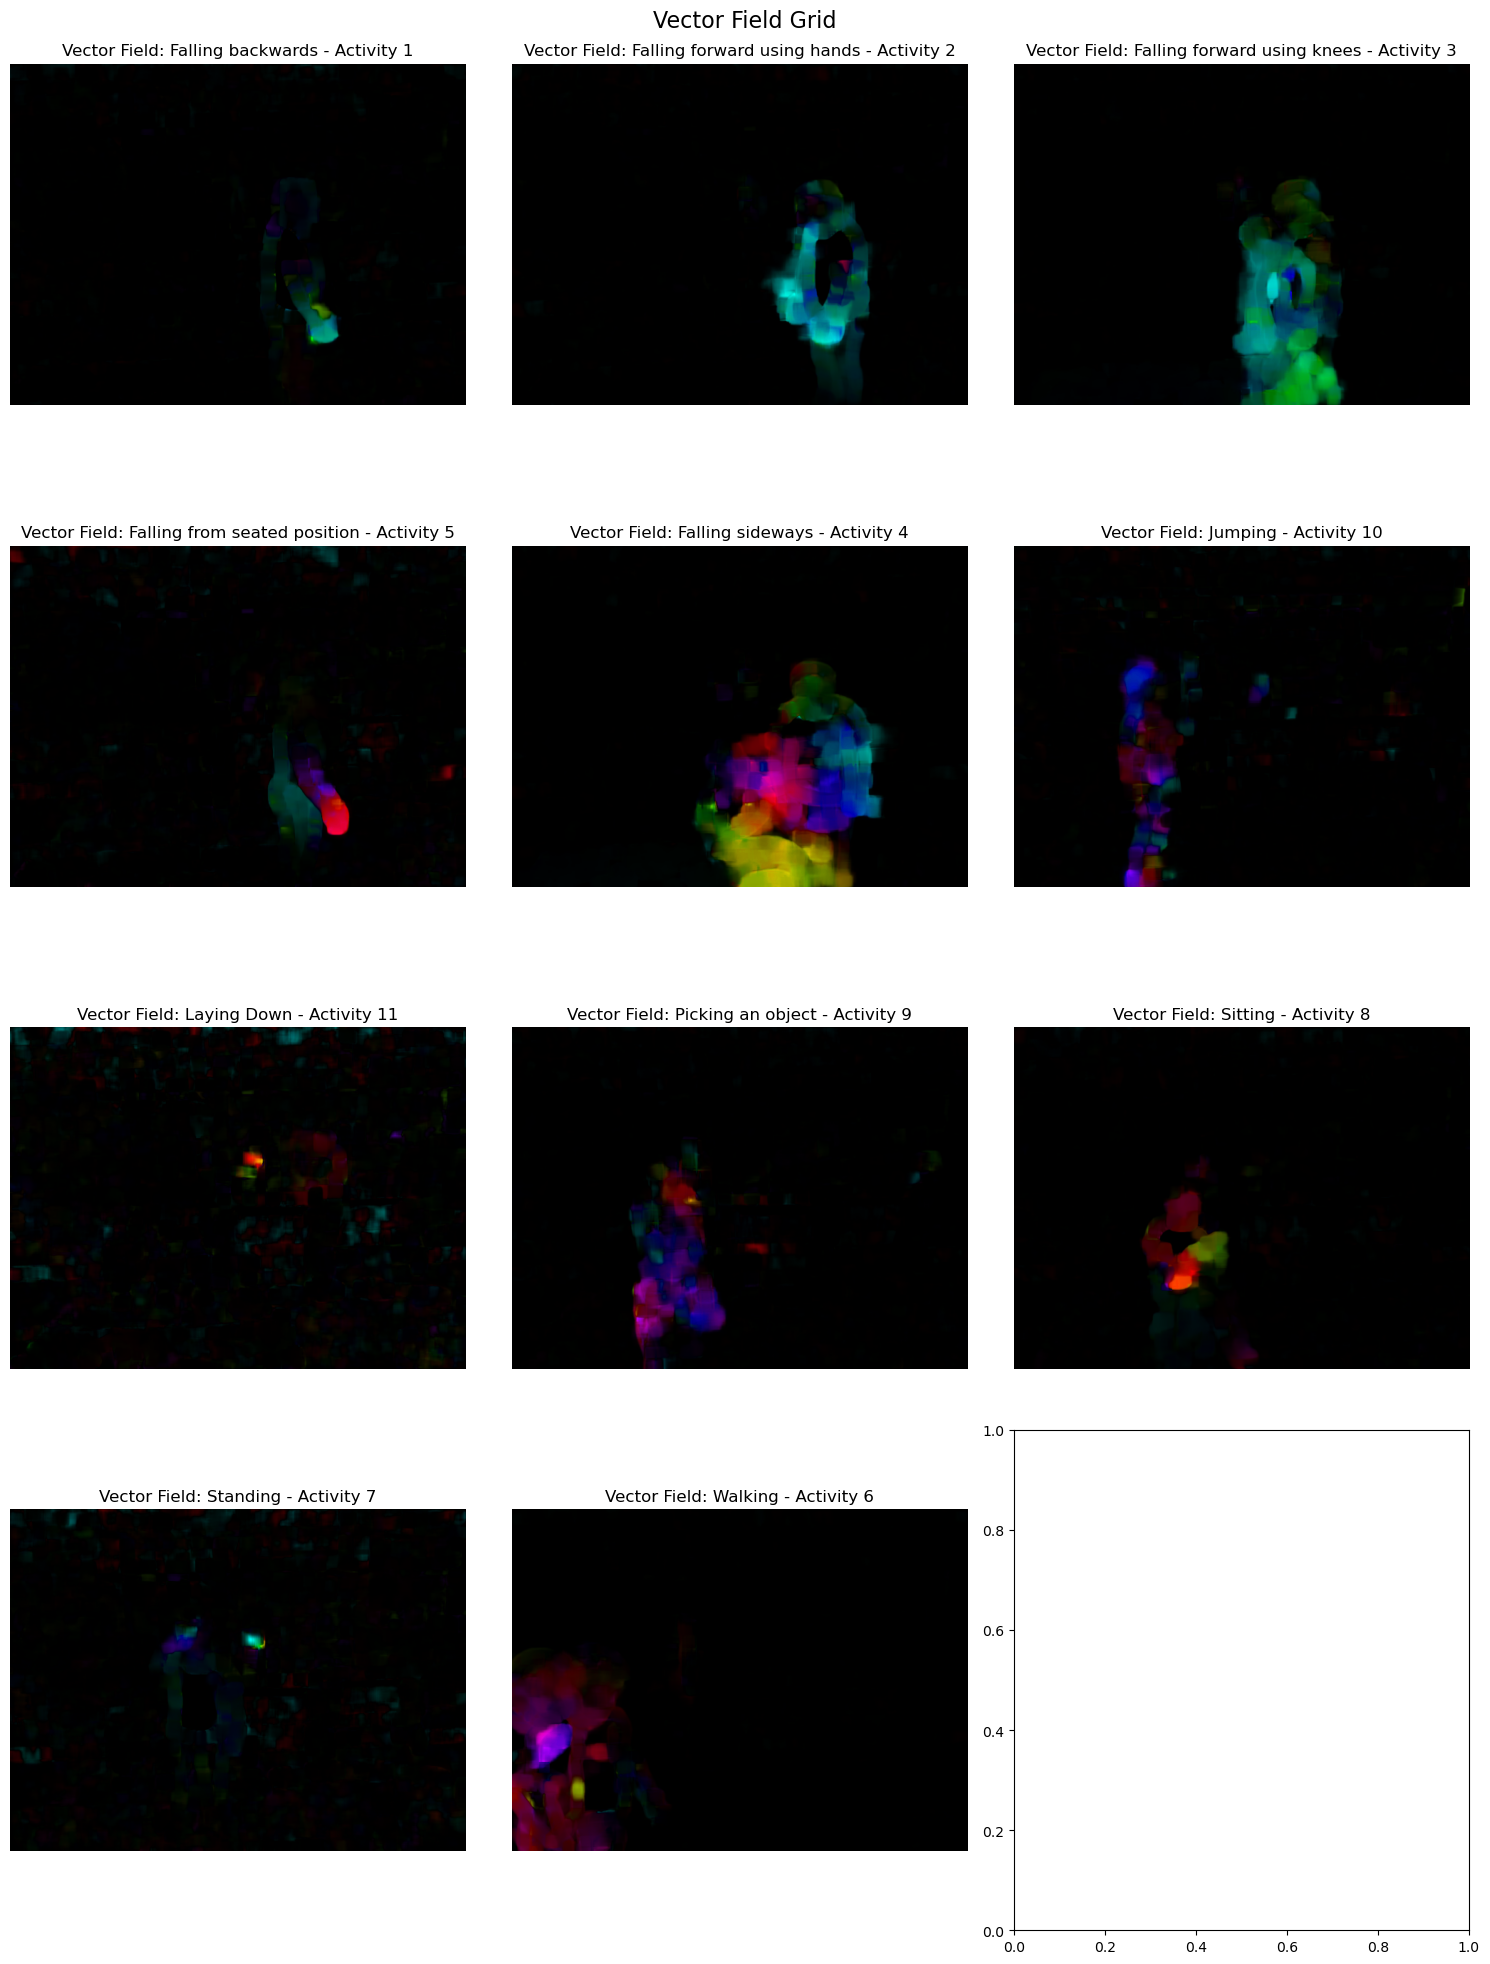

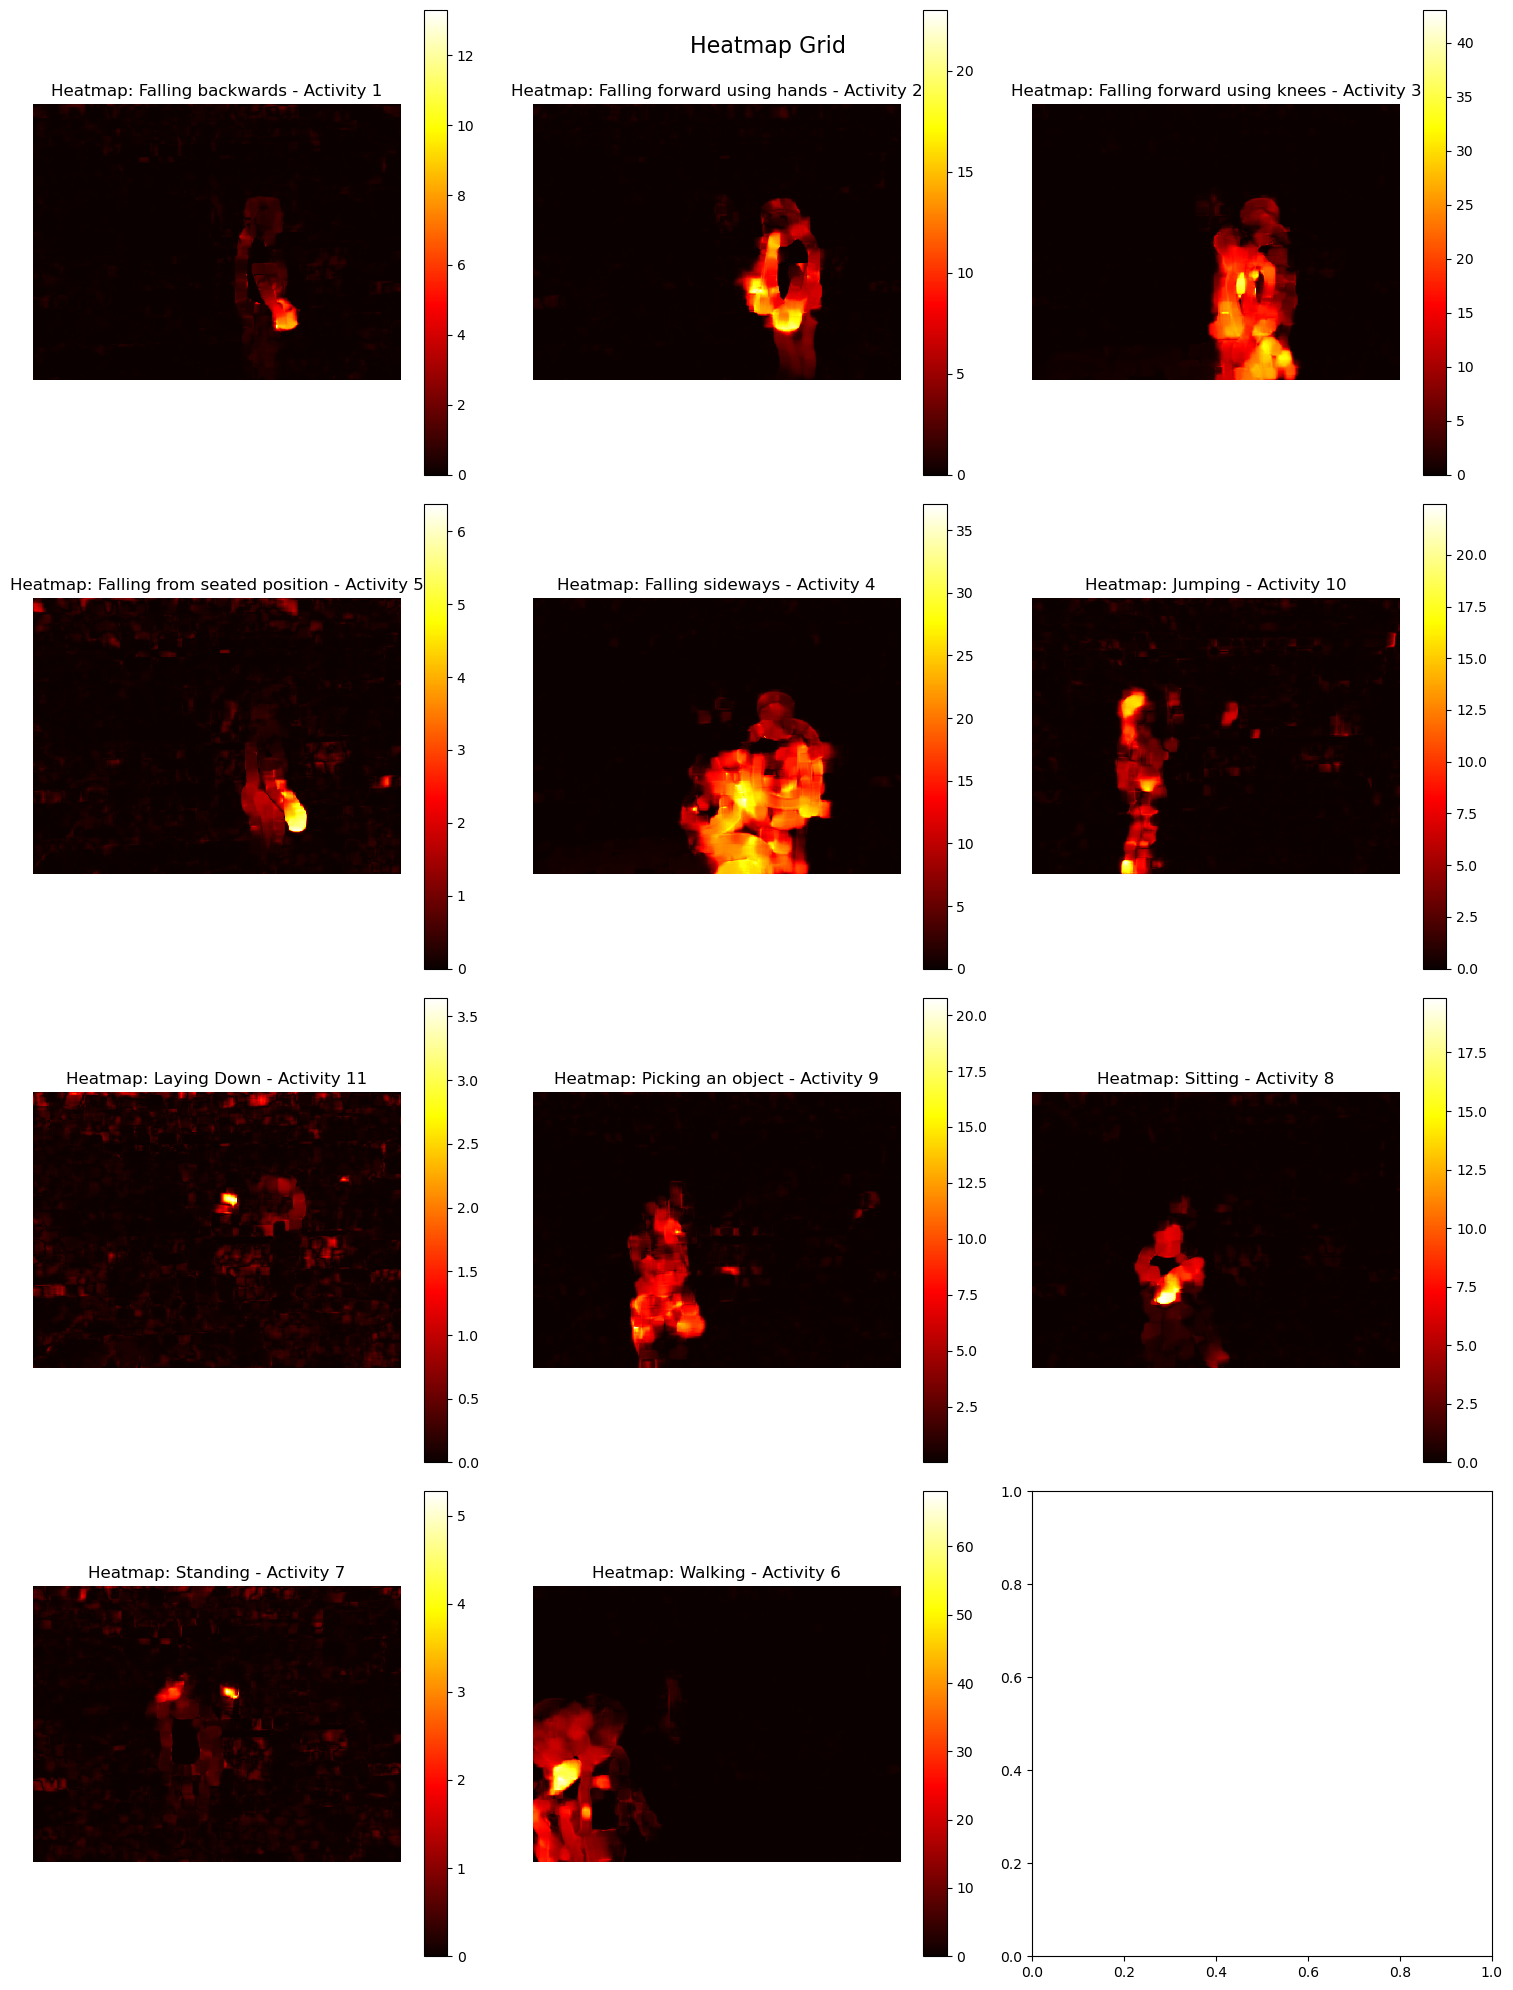

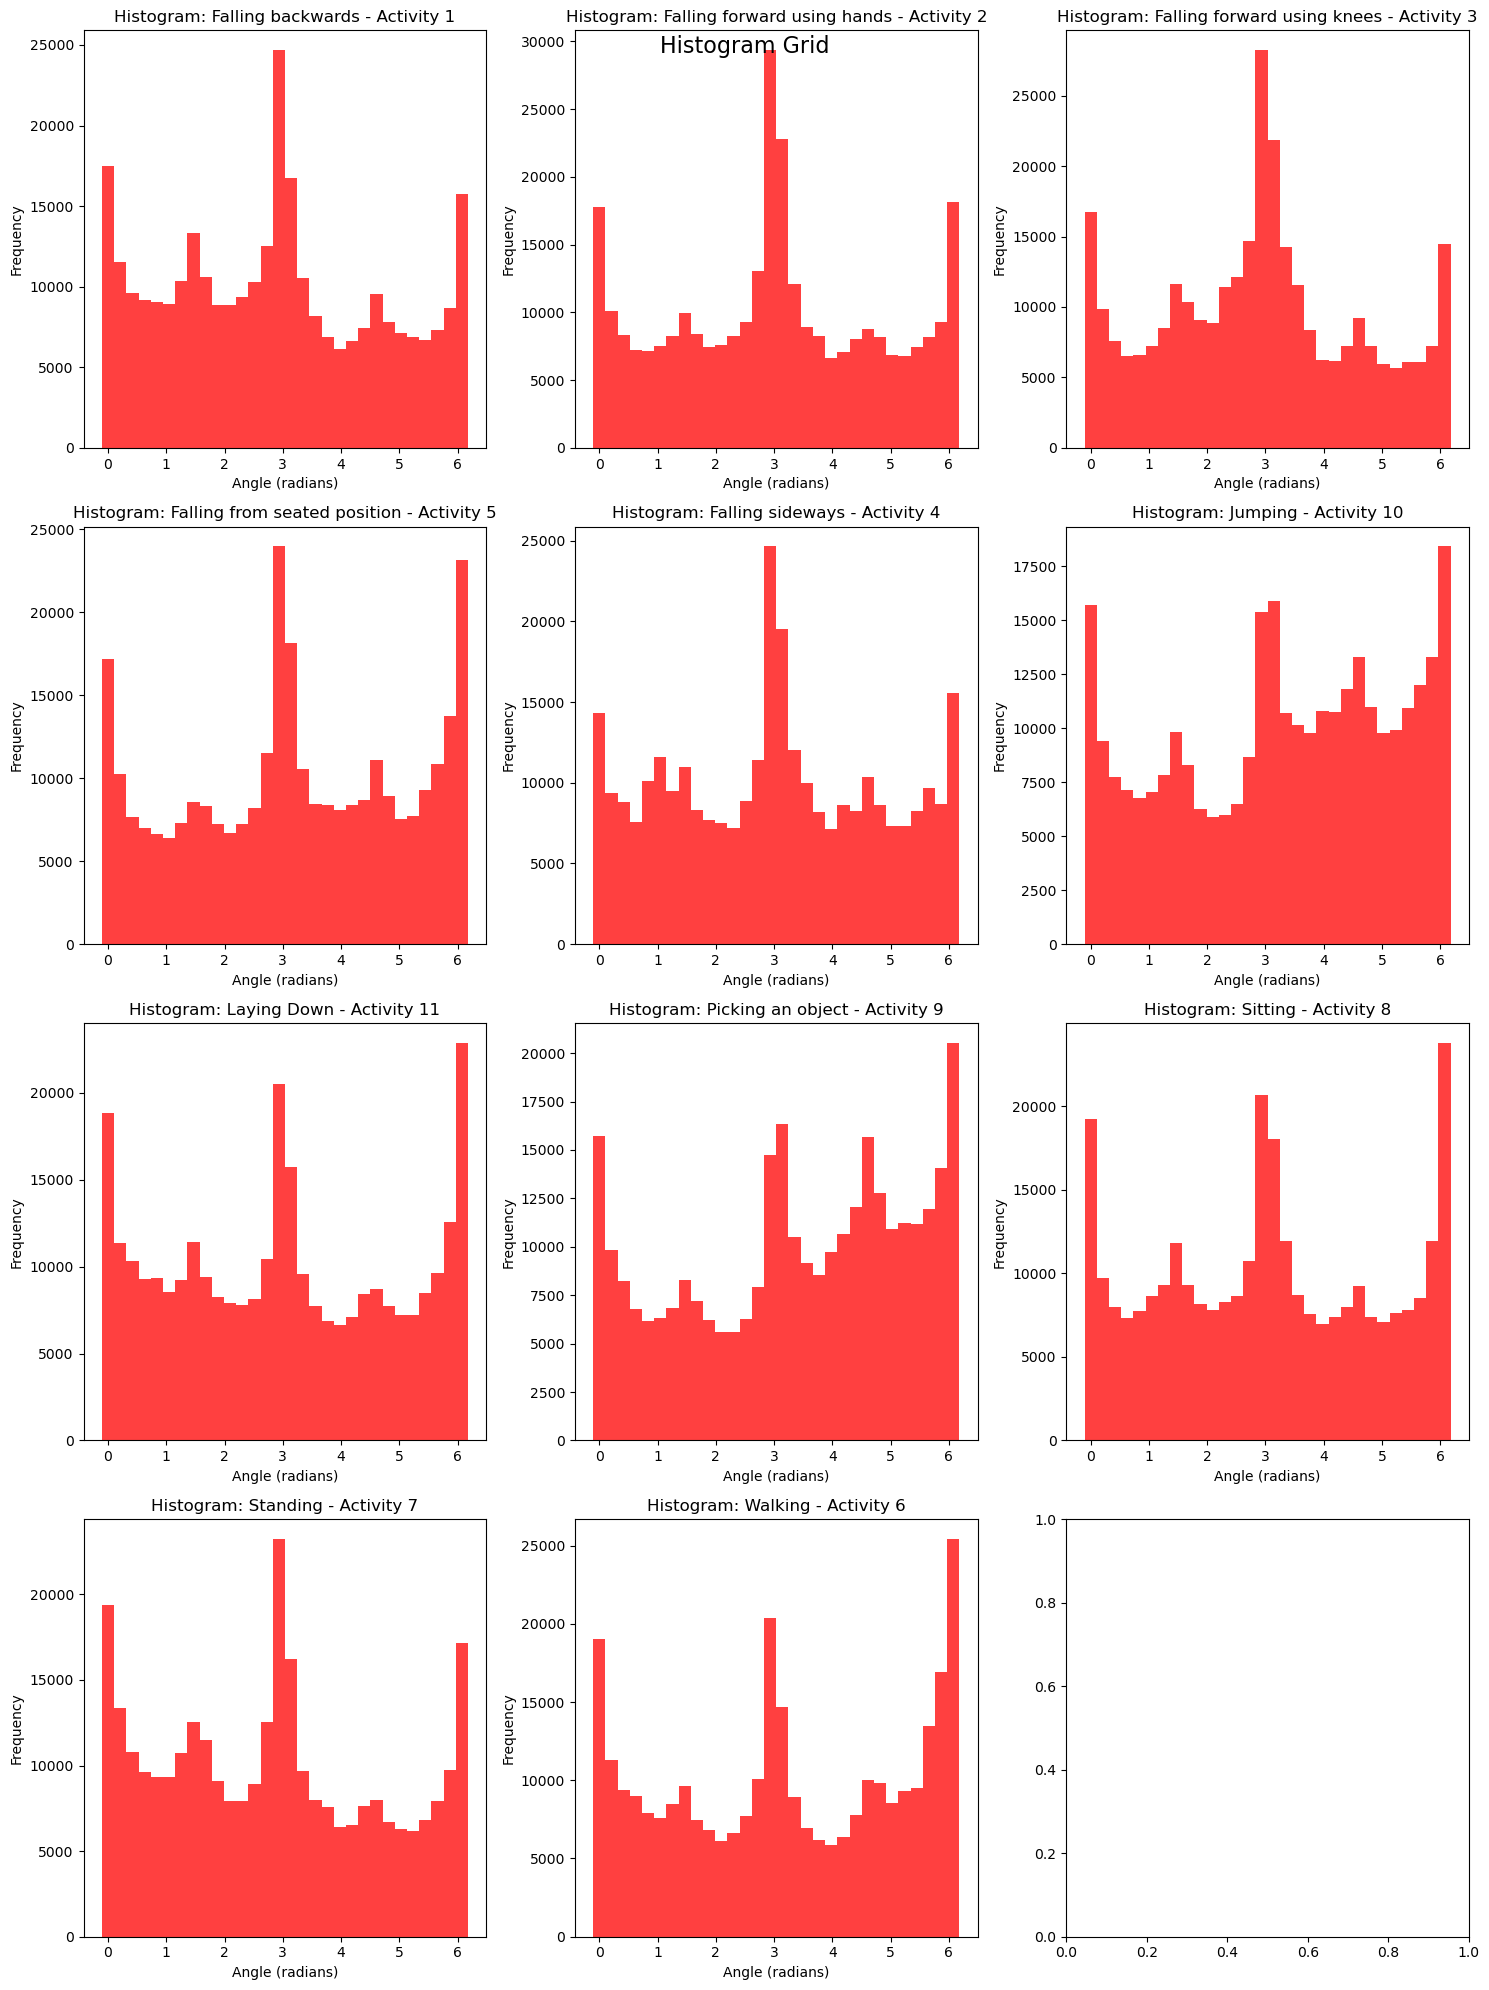

In [561]:
base_folder = "C:/Users/Admin/PycharmProjects/Fall Detection - Jupyter/UP Fall Dataset"
output_base = 'OF Image Results'
numpy_output_base = 'OF Numpy Results'
visualize_motion_analysis_grid(base_folder, output_base, numpy_output_base)

# Phase 2 - LSTM Model Workflow 

## Keypoint Prepration and Processing for LSTM 

In [335]:
features_dir = r"C:\Users\Admin\PycharmProjects\Fall Detection - Jupyter\Keypoints Numpy Results"

# Initialize lists to hold data and labels
X_kp = []
y_kp = []

# Mapping of folder names to numerical labels (for binary classification) where falls are 1 and non falls are 0 
label_map = {
    'Falling forward using hands - Activity 2': 1,
    'Falling backwards - Activity 1': 1,
    'Walking - Activity 6': 0,
    'Falling forward using knees - Activity 3': 1,
    'Falling from seated position - Activity 5': 1,
    'Falling sideways - Activity 4': 1,
    'Jumping - Activity 10': 0,
    'Laying Down - Activity 11': 0,
    'Sitting - Activity 8': 0,
    'Standing - Activity 7': 0,
    'Picking an object - Activity 9': 0,
}

# Loop through each folder (class) in the features directory
for folder_name in os.listdir(features_dir):
    folder_path = os.path.join(features_dir, folder_name)

    # Check if it is a directory
    if os.path.isdir(folder_path):
        label = label_map.get(folder_name, None)
        if label is None:
            print(f"Warning: Folder '{folder_name}' not found in label_map. Skipping...")
            continue

        # Loop through each saved feature file in the folder
        for filename in os.listdir(folder_path):
            feature_path = os.path.join(folder_path, filename)

            # Load the saved feature
            feature = np.load(feature_path)

            # Append the feature to X and the label to y
            X_kp.append(feature)
            y_kp.append(label)

# Convert lists to numpy arrays
X_kp = np.array(X_kp)
y_kp = np.array(y_kp)

# Normalize the feature data 
X_kp = X_kp.astype('float32')

# Split into training and testing sets
X_train_kp, X_test_kp, y_train_kp, y_test_kp = train_test_split(X_kp, y_kp, test_size=0.2, random_state=42)

print(f"X_train_kp shape: {X_train_kp.shape}")
print(f"y_train_kp shape: {y_train_kp.shape}")
print(f"X_test_kp shape: {X_test_kp.shape}")
print(f"y_test_kp shape: {y_test_kp.shape}")

X_train_kp shape: (80, 6, 17, 3)
y_train_kp shape: (80,)
X_test_kp shape: (20, 6, 17, 3)
y_test_kp shape: (20,)


In [337]:
# Define output directories for saved data
output_dir = 'Kp_LSTM_Prep'
os.makedirs(output_dir, exist_ok=True)

# Save the numpy arrays
np.save(os.path.join(output_dir, 'X_train_kp.npy'), X_train_kp)
np.save(os.path.join(output_dir, 'y_train_kp.npy'), y_train_kp)
np.save(os.path.join(output_dir, 'X_test_kp.npy'), X_test_kp)
np.save(os.path.join(output_dir, 'y_test_kp.npy'), y_test_kp)

print("Numpy arrays saved successfully.")

Numpy arrays saved successfully.


# KeyPoint LSTM Model Build 

In [366]:
output_folder = r"C:\Users\Admin\PycharmProjects\Fall Detection - Jupyter\LSTM_Keypoint_Outputs"
os.makedirs(output_folder, exist_ok=True)  

In [368]:
# Load prepared data
X_train = np.load(r'C:\Users\Admin\PycharmProjects\Fall Detection - Jupyter\Kp_LSTM_Prep\X_train_kp.npy')
X_test = np.load(r'C:\Users\Admin\PycharmProjects\Fall Detection - Jupyter\Kp_LSTM_Prep\X_test_kp.npy')
y_train = np.load(r'C:\Users\Admin\PycharmProjects\Fall Detection - Jupyter\Kp_LSTM_Prep\y_train_kp.npy')
y_test = np.load(r'C:\Users\Admin\PycharmProjects\Fall Detection - Jupyter\Kp_LSTM_Prep\y_test_kp.npy')

### Data Prep

In [371]:
# Convert labels to categorical (one-hot encoding)
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Reshape the data to fit LSTM input requirements
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], -1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], -1)) 

### KP_LSTM Build

In [632]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_44 (LSTM)                       │ (None, 480, 64)             │         180,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_45 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,634 (834.51 KB)

 Trainable params: 213,634 (834.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 918ms/step - accuracy: 0.4633 - loss: 0.7734 - val_accuracy: 0.2857 - val_loss: 0.8185
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5809 - loss: 0.6686 - val_accuracy: 0.7143 - val_loss: 0.6612
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step - accuracy: 0.6346 - loss: 0.6541 - val_accuracy: 0.7143 - val_loss: 0.6782
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step - accuracy: 0.7090 - loss: 0.6312 - val_accuracy: 0.7143 - val_loss: 0.6590
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step - accuracy: 0.6773 - loss: 0.6254 - val_accuracy: 0.7143 - val_loss: 0.6629
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step - accuracy: 0.6773 - loss: 0.6295 - val_accuracy: 0.7143 - val_loss: 0.6732
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step - accuracy: 0.7090 - loss: 0.6047 - val_accuracy: 0.5714 - val_loss: 0.7358
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - accuracy: 0.6346 - loss: 0.6345 - val_accuracy: 0.5714 - v

### Evaluate

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
LSTM Accuracy: 0.67
Confusion Matrix:
[[8 3]
 [3 4]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.73      0.73      0.73        11
     Class 1       0.57      0.57      0.57         7

    accuracy                           0.67        18
   macro avg       0.65      0.65      0.65        18
weighted avg       0.67      0.67      0.67        18



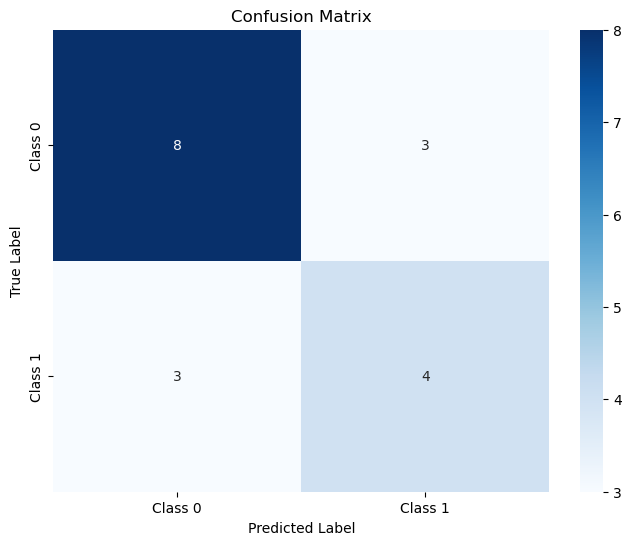

In [635]:
# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"LSTM Accuracy: {accuracy:.2f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix KP:")
print(conf_matrix)

# Print classification report
class_report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(num_classes)])
print("Classification Report KP:")
print(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(num_classes)], yticklabels=[f'Class {i}' for i in range(num_classes)])
plt.title('Confusion Matrix KP')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Optical Flow LSTM Model Build 

## Optical Flow Prepration and Processing for LSTM 

In [639]:
features_dir = r"C:\Users\Admin\PycharmProjects\Fall Detection - Jupyter\Key Motion Features Results"

In [641]:
# Initialize lists to hold data and labels
X_OF = []
y_OF = []

# Mapping of folder names to numerical labels (for binary classification)
label_map = {
    'Falling forward using hands - Activity 2': 1,
    'Falling backwards - Activity 1': 1,
    'Walking - Activity 6': 0,
    'Falling forward using knees - Activity 3': 1,
    'Falling from seated position - Activity 5': 1,
    'Falling sideways - Activity 4': 1,
    'Jumping - Activity 10': 0,
    'Laying Down - Activity 11': 0,
    'Sitting - Activity 8': 0,
    'Standing - Activity 7': 0,
    'Picking an object - Activity 9': 0,
}

In [643]:
# Loop through each folder (class) in the features directory
for folder_name in os.listdir(features_dir):
    folder_path = os.path.join(features_dir, folder_name)

    # Check if it is a directory
    if os.path.isdir(folder_path):
        label = label_map[folder_name]

        # Loop through each saved feature file in the folder
        for filename in os.listdir(folder_path):
            feature_path = os.path.join(folder_path, filename)
            feature = np.load(feature_path)

            # Resize feature if necessary
            if feature.shape[:2] != target_shape:
                feature = cv2.resize(feature, (target_shape[1], target_shape[0]))

            # Append the feature to X and the label to y
            X_OF.append(feature)
            y_OF.append(label)

In [645]:
# Convert lists to numpy arrays
X_OF = np.array(X_OF)
y_OF = np.array(y_OF)

# Normalize the feature data if needed
X_OF = X_OF.astype('float32')

In [647]:
# Split into training and testing sets
X_train_OF, X_test_OF, y_train_OF, y_test_OF = train_test_split(X_OF, y_OF, test_size=0.2, random_state=42)

print(f"X_train_OF shape: {X_train_OF.shape}")
print(f"y_train_OF shape: {y_train_OF.shape}")
print(f"X_test_OF shape: {X_test_OF.shape}")
print(f"y_test_OF shape: {y_test_OF.shape}")


X_train_OF shape: (68, 480, 640)
y_train_OF shape: (68,)
X_test_OF shape: (18, 480, 640)
y_test_OF shape: (18,)


In [649]:
# Define output directories for saved data
output_dir = 'OF_LSTM_prep'
os.makedirs(output_dir, exist_ok=True)

# Save the numpy arrays
np.save(os.path.join(output_dir, 'X_train_OF.npy'), X_train_OF)
np.save(os.path.join(output_dir, 'y_train_OF.npy'), y_train_OF)
np.save(os.path.join(output_dir, 'X_test_OF.npy'), X_test_OF)
np.save(os.path.join(output_dir, 'y_test_OF.npy'), y_test_OF)

print("Numpy arrays saved successfully.")


Numpy arrays saved successfully.


In [651]:
# Load prepared data
X_train_OF = np.load(r'C:\Users\Admin\PycharmProjects/Fall Detection - Jupyter/OF_LSTM_prep/X_train_OF.npy')
X_test_OF = np.load(r'C:\Users\Admin\PycharmProjects/Fall Detection - Jupyter/OF_LSTM_prep/X_test_OF.npy')
y_train_OF = np.load(r'C:\Users\Admin\PycharmProjects/Fall Detection - Jupyter/OF_LSTM_prep/y_train_OF.npy')
y_test_OF = np.load(r'C:\Users\Admin\PycharmProjects/Fall Detection - Jupyter/OF_LSTM_prep/y_test_OF.npy')

# Convert labels to categorical (one-hot encoding)
num_classes = len(np.unique(y_train_OF))
y_train_OF = to_categorical(y_train_OF, num_classes=num_classes)
y_test_OF = to_categorical(y_test_OF, num_classes=num_classes)

# Reshape the data to fit LSTM input requirements
X_train_OF = X_train_OF.reshape((X_train_OF.shape[0], X_train_OF.shape[1], -1))
X_test_OF = X_test_OF.reshape((X_test_OF.shape[0], X_test_OF.shape[1], -1))

## OF_LSTM Build

In [654]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train_OF.shape[1], X_train_OF.shape[2])))
model.add(LSTM(64))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train the model
history_OF = model.fit(X_train_OF, y_train_OF, epochs=100, batch_size=32, validation_split=0.1)




C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_46 (LSTM)                       │ (None, 480, 64)             │         180,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_47 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,634 (834.51 KB)

 Trainable params: 213,634 (834.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 943ms/step - accuracy: 0.6455 - loss: 0.6457 - val_accuracy: 0.2857 - val_loss: 0.8445
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step - accuracy: 0.6231 - loss: 0.6396 - val_accuracy: 0.5714 - val_loss: 0.7855
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - accuracy: 0.6767 - loss: 0.6203 - val_accuracy: 0.5714 - val_loss: 0.6729
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step - accuracy: 0.6137 - loss: 0.6626 - val_accuracy: 0.5714 - val_loss: 0.6804
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step - accuracy: 0.6241 - loss: 0.6391 - val_accuracy: 0.5714 - val_loss: 0.7229
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step - accuracy: 0.6450 - loss: 0.6391 - val_accuracy: 0.5714 - val_loss: 0.7213
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step - accuracy: 0.6346 - loss: 0.6243 - val_accuracy: 0.5714 - val_loss: 0.7603
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step - accuracy: 0.6346 - loss: 0.6253 - val_accuracy: 0.7143 - v

## Evaluate 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
LSTM Accuracy: 0.61
Confusion Matrix Optical Flow:
[[8 3]
 [3 4]]
Classification Report Optical Flow:
              precision    recall  f1-score   support

     Class 0       0.75      0.55      0.63        11
     Class 1       0.50      0.71      0.59         7

    accuracy                           0.61        18
   macro avg       0.62      0.63      0.61        18
weighted avg       0.65      0.61      0.61        18



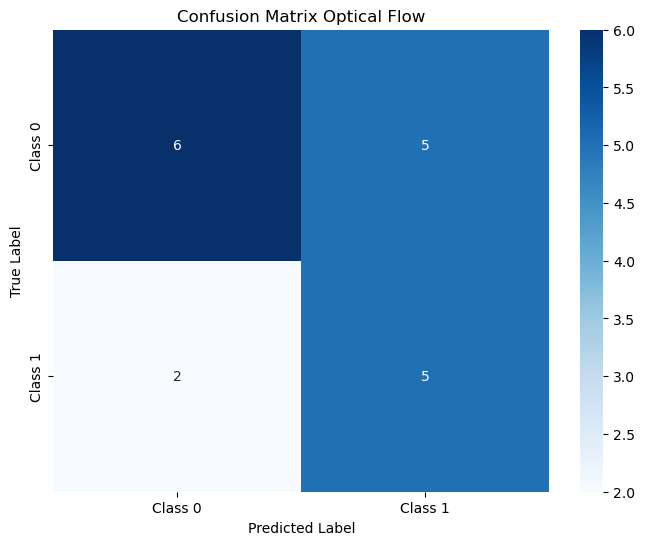

In [656]:
# Evaluate the model
y_pred_probs_OF = model.predict(X_test_OF)
y_pred_OF = np.argmax(y_pred_probs_OF, axis=1)
y_true_OF = np.argmax(y_test_OF, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_OF, y_pred_OF)
print(f"LSTM Accuracy: {accuracy:.2f}")

# Calculate confusion matrix
conf_matrix_of = confusion_matrix(y_true_OF, y_pred_OF)
print("Confusion Matrix Optical Flow:")
print(conf_matrix)

# Print classification report
class_report = classification_report(y_true_OF, y_pred_OF, target_names=[f'Class {i}' for i in range(num_classes)])
print("Classification Report Optical Flow:")
print(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_of, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(num_classes)], yticklabels=[f'Class {i}' for i in range(num_classes)])
plt.title('Confusion Matrix Optical Flow')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()